In [1]:
$import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [3]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, )#, dtype='Int64')


In [4]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [5]:
# visualisation des premiers lignes
data.head()

,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,10010000001,2,81,8,91,9,6,21,21,1,71,41,7,4,12,4,20,2,2,1,51,5,1.0
1,20010000006,1,75,7,43,4,6,6,13,2,71,64,7,6,12,9,4,12,4,13,12,1,1.0
2,30010000011,1,76,7,43,4,6,6,16,3,54,81,5,8,7,12,6,6,4,18,36,3,2.0
3,40010000013,3,75,7,43,4,4,6,13,1,71,36,7,3,12,11,11,19,4,6,21,2,1.0
4,50010000015,2,33,3,44,4,6,7,12,1,71,42,7,4,12,5,14,3,3,1,14,1,2.0


In [6]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train,shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def quarantiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne IFI+ :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)
    
    # création du tableau final en éliminant la colonne 2
    tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)



In [7]:
# élimination des individus n'ayant pas de valeurs pour la variable IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]


In [8]:
#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [9]:
data = data_sans_nan

In [10]:
data["Top_mon"].value_counts()

2    103659
1     23456
Name: Top_mon, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
####################################################################################
#                            MODELE 1 : BOOSTING
####################################################################################

In [ ]:
####################      AVEC LES VARIABLES DONS ET ENCODAGE DUMMIES        ###########################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [20] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params


{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 4,
 'n_estimators': 20}

test set : 
[[ 2496  2183]
 [ 7321 13423]]
              precision    recall  f1-score   support

           1       0.25      0.53      0.34      4679
           2       0.86      0.65      0.74     20744

    accuracy                           0.63     25423
   macro avg       0.56      0.59      0.54     25423
weighted avg       0.75      0.63      0.67     25423

train set : 
[[10711  8066]
 [28507 54408]]
              precision    recall  f1-score   support

           1       0.27      0.57      0.37     18777
           2       0.87      0.66      0.75     82915

    accuracy                           0.64    101692
   macro avg       0.57      0.61      0.56    101692
weighted avg       0.76      0.64      0.68    101692



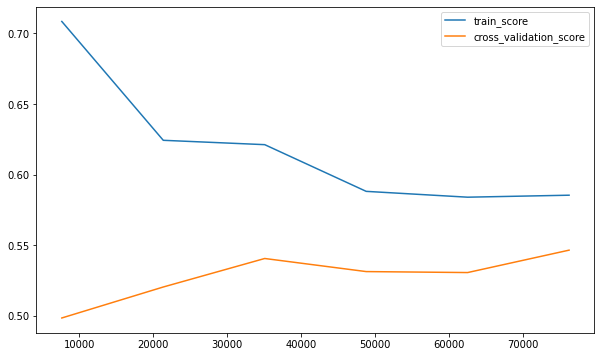

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="entropy",max_depth=4),n_estimators = 20 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#data_var_qualitatives_temp
quarantiles(model=final_model_AdaBoost, data_orig=data, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_dons_encodage_dummies_AdaBoost.xlsx")

                   IDENT     PROBA
20447    204480010263553  0.025010
95018    950190010408013  0.025134
10644    106450010255229  0.025195
29795    297960010339740  0.025383
83489    834900010398134  0.025545
...                  ...       ...
95743    957440010408713  0.859285
111837  1118380010521353  0.859500
107583  1075840010504930  0.859877
94514    945150010407536  0.860194
107668  1076690010505190  0.860451

[127115 rows x 2 columns]
0.500391    528
0.493059    429
0.497693    333
0.499617    291
0.498701    254
           ... 
0.498293      1
0.523241      1
0.493207      1
0.504709      1
0.488884      1
Name: PROBA, Length: 48995, dtype: int64
                    PROBA
20447   (0.02491, 0.4877]
95018   (0.02491, 0.4877]
10644   (0.02491, 0.4877]
29795   (0.02491, 0.4877]
83489   (0.02491, 0.4877]
...                   ...
95743    (0.5127, 0.8605]
111837   (0.5127, 0.8605]
107583   (0.5127, 0.8605]
94514    (0.5127, 0.8605]
107668   (0.5127, 0.8605]

[127115 rows x 1 column

In [ ]:
####################   SANS LES VARIABLES DONS ET ENCODAGE DUMMIES        ###########################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F","Onoma-Phase_Scl",
                "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [20] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params


{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 6,
 'n_estimators': 20}

test set : 
[[ 2497  2182]
 [ 7629 13115]]
              precision    recall  f1-score   support

           1       0.25      0.53      0.34      4679
           2       0.86      0.63      0.73     20744

    accuracy                           0.61     25423
   macro avg       0.55      0.58      0.53     25423
weighted avg       0.74      0.61      0.66     25423

train set : 
[[11352  7425]
 [28873 54042]]
              precision    recall  f1-score   support

           1       0.28      0.60      0.38     18777
           2       0.88      0.65      0.75     82915

    accuracy                           0.64    101692
   macro avg       0.58      0.63      0.57    101692
weighted avg       0.77      0.64      0.68    101692



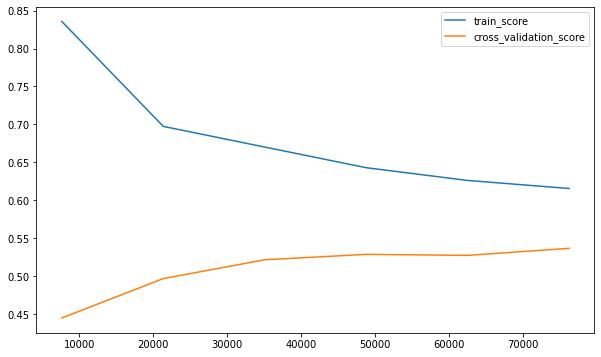

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="entropy",max_depth=6),n_estimators = 20 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_AdaBoost, data_orig=data, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_dons_encodage_dummies_AdaBoost.xlsx")

                   IDENT     PROBA
32284    322850010342417  0.000644
30077    300780010340001  0.003931
96698    966990010409586  0.004254
115802  1158030010526662  0.004276
114587  1145880010525561  0.004331
...                  ...       ...
42552    425530010355650  0.973251
90736    907370010404147  0.973752
90735    907360010404147  0.973752
102909  1029100010415966  0.973942
114086  1140870010525118  0.990096

[127115 rows x 2 columns]
0.492493    141
0.500801    135
0.501026    116
0.497037     92
0.500098     78
           ... 
0.500527      1
0.504458      1
0.495913      1
0.499360      1
0.498569      1
Name: PROBA, Length: 72501, dtype: int64
                     PROBA
32284   (-0.000356, 0.477]
30077   (-0.000356, 0.477]
96698   (-0.000356, 0.477]
115802  (-0.000356, 0.477]
114587  (-0.000356, 0.477]
...                    ...
42552        (0.513, 0.99]
90736        (0.513, 0.99]
90735        (0.513, 0.99]
102909       (0.513, 0.99]
114086       (0.513, 0.99]

[127115 row

In [ ]:
#############################################################
#                   MODELE 2 : RANDOM FOREST
#############################################################

In [ ]:



# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
model_RandomForestClassifier = RandomForestClassifier(class_weight="balanced", random_state =0 )
param = {'criterion': ['gini','entropy'], 'max_depth' : list(range(2,30, 2)),"max_features":[15,20,25] ,'n_estimators' : [20,30,50,100, 200] }

grid_RandomForestClassifier = GridSearchCV(model_RandomForestClassifier, param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_RandomForestClassifier = grid_RandomForestClassifier.fit(train_X_s, train_Y_s)
resultat_grid_RandomForestClassifier.best_params_


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'criterion': 'gini', 'max_depth': 2, 'max_features': 20, 'n_estimators': 50}

In [ ]:
model_RandomForestClassifier = RandomForestClassifier(class_weight="balanced", random_state =0 )
param = {'criterion': ['gini','entropy'], 'max_depth' : [2,3,4,5],"max_features":[19,20,21,200] ,'n_estimators' : [40,50,60] }

grid_RandomForestClassifier = GridSearchCV(model_RandomForestClassifier, param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_RandomForestClassifier = grid_RandomForestClassifier.fit(train_X_s, train_Y_s)
resultat_grid_RandomForestClassifier.best_params_


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 200,
 'n_estimators': 50}

In [ ]:
model_RandomForestClassifier = RandomForestClassifier(class_weight="balanced", random_state =0 )
param = {'criterion': ['gini','entropy'], 'max_depth' : [2,3,4,5],"max_features":[8,12,15,20,25] ,'n_estimators' : [20,50,100] }

grid_RandomForestClassifier = GridSearchCV(model_RandomForestClassifier, param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_RandomForestClassifier = grid_RandomForestClassifier.fit(train_X_s, train_Y_s)
resultat_grid_RandomForestClassifier.best_params_


{'criterion': 'gini', 'max_depth': 2, 'max_features': 12, 'n_estimators': 100}

test set : 
[[ 2937  1742]
 [10044 10700]]
              precision    recall  f1-score   support

           1       0.23      0.63      0.33      4679
           2       0.86      0.52      0.64     20744

    accuracy                           0.54     25423
   macro avg       0.54      0.57      0.49     25423
weighted avg       0.74      0.54      0.59     25423

train set : 
[[11846  6931]
 [39944 42971]]
              precision    recall  f1-score   support

           1       0.23      0.63      0.34     18777
           2       0.86      0.52      0.65     82915

    accuracy                           0.54    101692
   macro avg       0.54      0.57      0.49    101692
weighted avg       0.74      0.54      0.59    101692



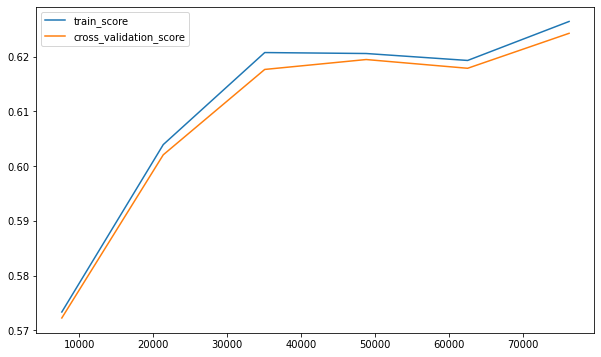

In [ ]:
final_model_RandomForestClassifier = RandomForestClassifier(class_weight="balanced", criterion="gini", max_depth=2, max_features=12, n_estimators = 100, random_state=0) 
evaluation(final_model_RandomForestClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall")

In [ ]:
quarantiles(model=final_model_RandomForestClassifier, data_orig=data, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_dons_encodage_dummies_AdaBoost.xlsx")

                   IDENT     PROBA
16353    163540010259655  0.443020
81243    812440010396251  0.443104
81244    812450010396251  0.443104
55216    552170010367865  0.443528
101475  1014760010414774  0.444116
...                  ...       ...
126631  1266320010538813  0.591604
19563    195640010262550  0.591604
46136    461370010360285  0.591604
126630  1266310010538813  0.591604
95649    956500010408568  0.591691

[127115 rows x 2 columns]
0.513126    377
0.513624    324
0.514471    321
0.466538    319
0.463450    273
           ... 
0.512342      1
0.470694      1
0.499040      1
0.494265      1
0.515184      1
Name: PROBA, Length: 46517, dtype: int64
                 PROBA
16353   (0.442, 0.458]
81243   (0.442, 0.458]
81244   (0.442, 0.458]
55216   (0.442, 0.458]
101475  (0.442, 0.458]
...                ...
126631  (0.536, 0.592]
19563   (0.536, 0.592]
46136   (0.536, 0.592]
126630  (0.536, 0.592]
95649   (0.536, 0.592]

[127115 rows x 1 columns]
Top_mon            1     2  TOTAL

In [ ]:
###################################################################################################################@
###################################################################################################################@
#                                   DECISION TREE CLASSIFIER  ----  AVEC VARIABLES QUALITATIVES
###################################################################################################################@
###################################################################################################################@

In [ ]:
####################################################################################
####################################################################################
#                   TEST AVEC TOUTES LES VARIABLES
####################################################################################
####################################################################################

In [12]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,30,2)),
         'min_samples_split' : [0.05, 0.1, 0.4, 0.6, 0.8, 1] }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 21,
 'min_samples_split': 0.05}

test set : 
[[ 3627  1052]
 [13885  6859]]
              precision    recall  f1-score   support

           1       0.21      0.78      0.33      4679
           2       0.87      0.33      0.48     20744

    accuracy                           0.41     25423
   macro avg       0.54      0.55      0.40     25423
weighted avg       0.75      0.41      0.45     25423

train set : 
[[14518  4259]
 [55648 27267]]
              precision    recall  f1-score   support

           1       0.21      0.77      0.33     18777
           2       0.86      0.33      0.48     82915

    accuracy                           0.41    101692
   macro avg       0.54      0.55      0.40    101692
weighted avg       0.74      0.41      0.45    101692



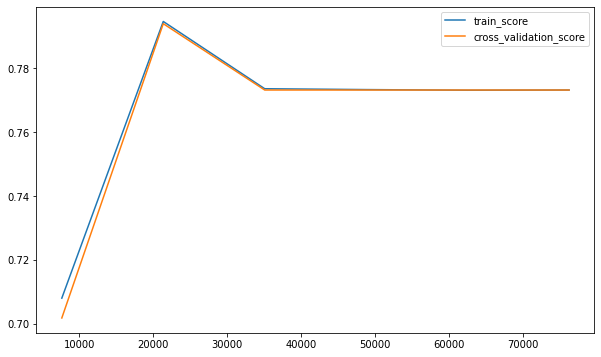

In [13]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=21, min_samples_split=0.05 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [14]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig = data, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                   IDENT     PROBA
0            10010000001  0.399154
43169    431700010357912  0.399154
43172    431730010357915  0.399154
43173    431740010357916  0.399154
43174    431750010357917  0.399154
...                  ...       ...
53999    540000010366915  0.535420
53998    539990010366914  0.535420
53997    539980010366913  0.535420
54007    540080010366920  0.535420
127114  1271150010539470  0.535420

[127115 rows x 2 columns]
0.535420    69030
0.399154    33192
0.534965    18648
0.453157     6245
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)
plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)


In [ ]:
####################################################################################
####################################################################################
#                   TEST SANS LES VARIABLES ILLUSTRATIVES DE SPAD
####################################################################################
####################################################################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F",
                "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,30,2)),
         'min_samples_split' : [0.05, 0.1, 0.4, 0.6, 0.8, 1] }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 5,
 'min_samples_split': 1.0}

test set : 
[[  390  4289]
 [  611 20133]]
              precision    recall  f1-score   support

           1       0.39      0.08      0.14      4679
           2       0.82      0.97      0.89     20744

    accuracy                           0.81     25423
   macro avg       0.61      0.53      0.51     25423
weighted avg       0.74      0.81      0.75     25423

train set : 
[[ 1539 17238]
 [ 2379 80536]]
              precision    recall  f1-score   support

           1       0.39      0.08      0.14     18777
           2       0.82      0.97      0.89     82915

    accuracy                           0.81    101692
   macro avg       0.61      0.53      0.51    101692
weighted avg       0.74      0.81      0.75    101692



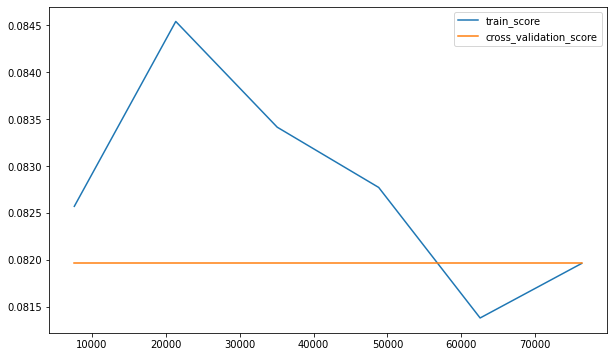

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 50, max_features=30, min_samples_split=1.0 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig = data_var_qualitatives_temp, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                     IDENT     PROBA
473080    3459660160002552  0.395492
252445    1253310050065321  0.395492
979346    8522320360028695  0.395492
979344    8522300360028693  0.395492
1137579  10104650370026928  0.395492
...                    ...       ...
415250    2881360130035415  0.503694
415249    2881350130035414  0.503694
415248    2881340130035413  0.503694
415227    2881130130035392  0.503694
1219998  10928840370109347  0.503694

[1219999 rows x 2 columns]
0.503694    1171011
0.395492      48988
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
train_X_s.shape

(101692, 374)

In [ ]:
np.sqrt(374)

19.339079605813716

In [ ]:
np.linspace(0.1, 1,5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [ ]:
0.05, 0.1, 0.4, 0.6, 0.8, 1